In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import concat
%matplotlib inline

In [2]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('td13_add_new.csv')

In [3]:
print(dataset.head(5))

         ����ʱ��  ���й����ʣ�kw��  ����״��  ����¶�  ����¶�.1  �����������  \
0  2018/1/1 0:00     244033.7682      2.0    22.0      12.0          1.0   
1  2018/1/1 0:15     232720.6402      2.0    22.0      12.0          1.0   
2  2018/1/1 0:30     231685.6891      2.0    22.0      12.0          1.0   
3  2018/1/1 0:45     227581.3317      2.0    22.0      12.0          1.0   
4  2018/1/1 1:00     233482.4269      2.0    22.0      12.0          1.0   

   ҹ����������  ��  ��.1  Сʱ  һ��ڼ���  һ��ڼ���.1  weekday  ʱ���  ����  �Ƿ��³�  \
0          1.0   1     1   0        1          1        0     1     1       1   
1          1.0   1     1   0        1          1        0     1     1       1   
2          1.0   1     1   0        1          1        0     1     1       1   
3          1.0   1     1   0        1          1        0     1     1       1   
4          1.0   1     1   1        1          1        0     1     1       1   

   �Ƿ���ĩ  �Ƿ񼾽ڳ�  �Ƿ񼾽�ĩ  �Ƿ���ĩ.1  
0       0      1    

In [4]:
# manually specify column names
#dataset.drop('Unnamed: 0 ', axis=1, inplace=True)

In [5]:
print(dataset.head(5))

         ����ʱ��  ���й����ʣ�kw��  ����״��  ����¶�  ����¶�.1  �����������  \
0  2018/1/1 0:00     244033.7682      2.0    22.0      12.0          1.0   
1  2018/1/1 0:15     232720.6402      2.0    22.0      12.0          1.0   
2  2018/1/1 0:30     231685.6891      2.0    22.0      12.0          1.0   
3  2018/1/1 0:45     227581.3317      2.0    22.0      12.0          1.0   
4  2018/1/1 1:00     233482.4269      2.0    22.0      12.0          1.0   

   ҹ����������  ��  ��.1  Сʱ  һ��ڼ���  һ��ڼ���.1  weekday  ʱ���  ����  �Ƿ��³�  \
0          1.0   1     1   0        1          1        0     1     1       1   
1          1.0   1     1   0        1          1        0     1     1       1   
2          1.0   1     1   0        1          1        0     1     1       1   
3          1.0   1     1   0        1          1        0     1     1       1   
4          1.0   1     1   1        1          1        0     1     1       1   

   �Ƿ���ĩ  �Ƿ񼾽ڳ�  �Ƿ񼾽�ĩ  �Ƿ���ĩ.1  
0       0      1    

In [6]:
dataset.columns = ['time','总有功功率 （kw）','天气状况','最高温度','最低温度','白天风力风向','夜晚风力风向','月','天','小时','一年第几天','一年第几周','weekday','时间段','季节','是否月初','是否月末','是否季节初','是否季节末','是否周末']

In [7]:
dataset.drop('time', axis=1, inplace=True)
# summarize first 5 rows
#print(dataset.head(5))
# save to file
dataset.to_csv('power.csv')

In [8]:
print(dataset)

         总有功功率 （kw）  天气状况  最高温度  最低温度  白天风力风向  夜晚风力风向   月   天  小时  一年第几天  \
0       244033.7682  2.00  22.0  12.0     1.0     1.0   1   1   0      1   
1       232720.6402  2.00  22.0  12.0     1.0     1.0   1   1   0      1   
2       231685.6891  2.00  22.0  12.0     1.0     1.0   1   1   0      1   
3       227581.3317  2.00  22.0  12.0     1.0     1.0   1   1   0      1   
4       233482.4269  2.00  22.0  12.0     1.0     1.0   1   1   1      1   
...             ...   ...   ...   ...     ...     ...  ..  ..  ..    ...   
137275  188526.9574  1.15  22.5  14.2    20.4    17.4  11  30   0    334   
137276  202457.0970  1.15  22.5  14.2    20.4    17.4  11  30   0    334   
137277  185634.1142  1.15  22.5  14.2    20.4    17.4  11  30   0    334   
137278  184531.0964  1.15  22.5  14.2    20.4    17.4  11  30   0    334   
137279  184605.9313  1.15  22.5  14.2    20.4    17.4  11  30   0    334   

        一年第几周  weekday  时间段  季节  是否月初  是否月末  是否季节初  是否季节末  是否周末  
0           1        

In [9]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('power.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
#print(reframed.head())
print(reframed.head)

<bound method NDFrame.head of         var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.672707    0.12500   0.483871   0.346154   0.000000   0.000000   
2        0.643219    0.12500   0.483871   0.346154   0.000000   0.000000   
3        0.640521    0.12500   0.483871   0.346154   0.000000   0.000000   
4        0.629823    0.12500   0.483871   0.346154   0.000000   0.000000   
5        0.645205    0.12500   0.483871   0.346154   0.000000   0.000000   
...           ...        ...        ...        ...        ...        ...   
137275   0.530375    0.01875   0.500000   0.430769   0.710526   0.713044   
137276   0.528027    0.01875   0.500000   0.430769   0.710526   0.713044   
137277   0.564336    0.01875   0.500000   0.430769   0.710526   0.713044   
137278   0.520487    0.01875   0.500000   0.430769   0.710526   0.713044   
137279   0.517612    0.01875   0.500000   0.430769   0.710526   0.713044   

        var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var1

In [10]:
#plt.plot(reframed)
#plt.show()

In [11]:
...
# split into train and test sets
values = reframed.values
n_train_hours = int(len(reframed)-91*96)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(128543, 1, 19) (128543,) (8736, 1, 19) (8736,)


Epoch 1/100
1786/1786 - 3s - loss: 0.0576 - val_loss: 0.0414 - 3s/epoch - 2ms/step
Epoch 2/100
1786/1786 - 2s - loss: 0.0336 - val_loss: 0.0265 - 2s/epoch - 989us/step
Epoch 3/100
1786/1786 - 2s - loss: 0.0288 - val_loss: 0.0253 - 2s/epoch - 1ms/step
Epoch 4/100
1786/1786 - 2s - loss: 0.0279 - val_loss: 0.0253 - 2s/epoch - 1ms/step
Epoch 5/100
1786/1786 - 2s - loss: 0.0273 - val_loss: 0.0249 - 2s/epoch - 1ms/step
Epoch 6/100
1786/1786 - 2s - loss: 0.0269 - val_loss: 0.0242 - 2s/epoch - 1ms/step
Epoch 7/100
1786/1786 - 2s - loss: 0.0266 - val_loss: 0.0240 - 2s/epoch - 1ms/step
Epoch 8/100
1786/1786 - 2s - loss: 0.0263 - val_loss: 0.0239 - 2s/epoch - 1ms/step
Epoch 9/100
1786/1786 - 2s - loss: 0.0262 - val_loss: 0.0237 - 2s/epoch - 1ms/step
Epoch 10/100
1786/1786 - 2s - loss: 0.0260 - val_loss: 0.0237 - 2s/epoch - 993us/step
Epoch 11/100
1786/1786 - 2s - loss: 0.0259 - val_loss: 0.0237 - 2s/epoch - 989us/step
Epoch 12/100
1786/1786 - 2s - loss: 0.0258 - val_loss: 0.0237 - 2s/epoch - 992u

Epoch 98/100
1786/1786 - 2s - loss: 0.0213 - val_loss: 0.0314 - 2s/epoch - 974us/step
Epoch 99/100
1786/1786 - 2s - loss: 0.0214 - val_loss: 0.0316 - 2s/epoch - 997us/step
Epoch 100/100
1786/1786 - 2s - loss: 0.0213 - val_loss: 0.0316 - 2s/epoch - 1ms/step


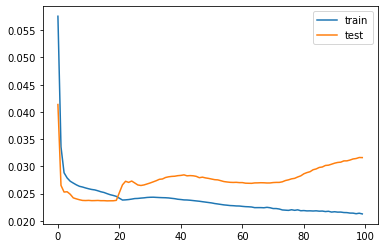

In [12]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
# make predictions
#trainPredict = model.predict(train_X)
#testPredict = model.predict(test_X)

In [14]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [15]:
yhat=DataFrame(yhat)
test_X=DataFrame(test_X)
print(yhat.shape,test_X.shape)

(8736, 1) (8736, 19)


In [16]:
test_X[0]=yhat
test_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.560584,1.00000,0.806452,0.884615,0.947368,0.913043,0.636364,1.000000,1.0,0.663014,0.653846,0.166667,0.0,0.666667,0.0,1.0,0.0,0.0,0.0
1,0.581699,0.34375,0.877419,0.909615,0.605263,0.669565,0.727273,0.000000,0.0,0.665753,0.653846,0.333333,0.0,0.666667,1.0,0.0,0.0,0.0,0.0
2,0.568715,0.34375,0.877419,0.909615,0.605263,0.669565,0.727273,0.000000,0.0,0.665753,0.653846,0.333333,0.0,0.666667,1.0,0.0,0.0,0.0,0.0
3,0.568211,0.34375,0.877419,0.909615,0.605263,0.669565,0.727273,0.000000,0.0,0.665753,0.653846,0.333333,0.0,0.666667,1.0,0.0,0.0,0.0,0.0
4,0.567525,0.34375,0.877419,0.909615,0.605263,0.669565,0.727273,0.000000,0.0,0.665753,0.653846,0.333333,0.0,0.666667,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,0.542528,0.01875,0.500000,0.430769,0.710526,0.713044,0.909091,0.966667,0.0,0.912329,0.903846,0.166667,0.0,1.000000,0.0,1.0,0.0,0.0,0.0
8732,0.541916,0.01875,0.500000,0.430769,0.710526,0.713044,0.909091,0.966667,0.0,0.912329,0.903846,0.166667,0.0,1.000000,0.0,1.0,0.0,0.0,0.0
8733,0.551537,0.01875,0.500000,0.430769,0.710526,0.713044,0.909091,0.966667,0.0,0.912329,0.903846,0.166667,0.0,1.000000,0.0,1.0,0.0,0.0,0.0
8734,0.539962,0.01875,0.500000,0.430769,0.710526,0.713044,0.909091,0.966667,0.0,0.912329,0.903846,0.166667,0.0,1.000000,0.0,1.0,0.0,0.0,0.0


In [17]:
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [18]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]=test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [19]:
# calculate RMSE
from math import sqrt
#trainScore = sqrt(mean_squared_error(train_y[0], inv_yhat[0]))
#print('Train Score: %.3f RMSE' % (trainScore))
rmse2 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.3f' % rmse2)

Test Score: 15109.746


In [20]:
inv_y

array([210161.97, 198264.28, 197798.58, ..., 185634.11, 184531.11,
       184605.95], dtype=float32)

In [21]:
print(len(inv_y),len(inv_yhat))

8736 8736


In [22]:
inv_yhat

array([201017.6 , 209118.45, 204136.94, ..., 197546.72, 193106.05,
       192821.62], dtype=float32)

In [23]:
import numpy as np
from sklearn import metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
print('MAPE:',mape(inv_y, inv_yhat))

MAPE: 0.05577283


In [24]:
from sklearn.metrics import r2_score
print('R2-score:',r2_score(inv_y, inv_yhat))

R2-score: 0.5139100586940618


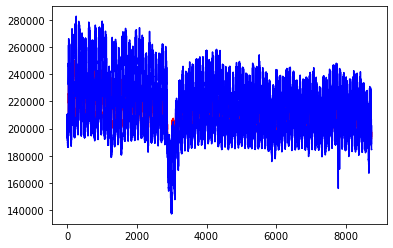

In [25]:
plt.plot(inv_yhat,'r')
plt.plot(inv_y,'b')

In [27]:
import pandas as pd
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.to_csv('prediction_8736.csv')